# 简历技能中提到的LR、CNN、RNN、Transformer
## 1.逻辑回归
&emsp;&emsp;逻辑回归是我在学习评分卡建模时系统接触的，它非常适合二分类+可解释性要求高的场景，比如信贷风控<br>
&emsp;&emsp;逻辑回归假设数据服从伯努利分布，通过最大似然函数估计来确定模型的参数，以最大化数据的似然函数（也是它的损失函数），通常使用梯度下降等优化算法找到最佳参数。<br>
&emsp;&emsp;**优点**：形式简单、模型可解释性非常好；数学性质好，易于优化；不仅可以预测类别，还可以得到概率预测；模型可以作为baseline。<br>
&emsp;&emsp;**缺点**：很难处理数据不平衡的问题，比如正负样本10000:1。
## 2. CNN
&emsp;&emsp;CNN是在做图像分类任务时使用到的，主要是基于AlexNet的预训练权重进行微调。<br>
&emsp;&emsp;CNN局部感受野、权值共享的特性更适合图像；具体使用预训练的AlexNet，冻结前面卷积层，只微调后面的全连接层；小数据集下迁移学习比从零训练效果好。<br>
## 3. RNN
&emsp;&emsp;RNN是用来理解序列建模和上下文依赖的，RNN通过隐藏状态建模时间序列/文本序列，理论上可以捕捉上下文信息。<br>
&emsp;&emsp;但长序列下会有梯度消失/梯度爆炸，RNN与前馈神经网络不同，后者不保留先前输入的信息，而RNN通过隐藏状态保持时间序列的上下文信息。<br>

## 4. Transformer
&emsp;&emsp;Transformer是在学习大模型时重点研究的架构，
### 4.1 手撕Transformer

### 4.2 scaled dot-product Attention什么要进行缩放
&emsp;&emsp;一句话总结：**scaled attention 是为了防止高维向量点积过大，导致softmax饱和和梯度消失，从而让训练更加稳定。** <br>
&emsp;&emsp;在**scaled Dot-product Attention**里，为什么做softmax之前要把attention score除以$\sqrt{d_{k}}$，核心原因额可以从**数值稳定性+梯度行为+统计尺寸**三个角度理解。<br>
&emsp;&emsp;参考内容：[为什么在进行softmax之前需要对attention进行scaled](https://blog.csdn.net/ytusdc/article/details/121622205)、[self-attention为什么要除以根号d_k](https://blog.csdn.net/suibianshen2012/article/details/122141294)、[self Attention为何除以根号dk？（全新角度）](https://blog.csdn.net/weixin_74152658/article/details/146411588)、[手撕self-attention代码_从0实现self-attention_附学习路线](https://blog.csdn.net/qq_44949041/article/details/128087174)<br>
#### 4.2.1. 问题背景：attention的打分方式
在Transformer中，attention score通常是：<br>
\begin{equation}\mathrm{score}=QK^\top\tag{1}\end{equation}
其中，$Q,K\in\mathbb{R}^{d_k}$，$d_{k}$是key或者query的维度，然后再做：
\begin{equation}\mathrm{Attention}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V\tag{2}\end{equation}

#### 4.2.2. 如果不scaled，会发生什么？
**点积的数值会随着维度变大**<br>
方差是刻画随机变量在其中心位置附近散布程度的数学特征，反应了随机变量取值的离散程度。<br>
假设：
$Q_{i},K_{i}$的各维是零均值、方差为1的随机变量，那么点积：
\begin{equation}Q\cdot K=\sum_{i=1}^{d_k}Q_iK_i\tag{3}\end{equation}
其数学属性是，均值为0，方差为$d_{k}$。也就是说：$d_{k}$越大，attention score的分布越宽，数值越大。<br>
**点积的统计特性分析**<br>
根据独立随机变量和的方差性质，点积的方差为：
\begin{equation}\mathrm{Var}(Q\cdot K)=\sum_{i=1}^{d_k}\mathrm{Var}(Q_iK_i)\tag{4}\end{equation}
Assume: $X = {Q_i}$,$Y = {K_i}$，那么：<br>
$
1、 E(XY) = E(X)E(Y) = 0 \times 0 = 0
$<br>
$\begin{aligned}
2、 D(XY) &= E(X^2 Y^2) - [E(XY)]^2 \\
      &= E(X^2) E(Y^2) - [E(X)E(Y)]^2 \\
      &= [E(X^2) - 0][E(Y^2) - 0] - [E(X)E(Y)]^2 \\
      &= [E(X^2) - (E(X))^2][E(Y^2) - (E(Y))^2] - [E(X)E(Y)]^2 \\
      &= D(X) D(Y) - [E(X)E(Y)]^2 \\
      &= 1 \times 1 - 0 \\
      &= 1= \mathrm{Var}(XY)=\mathrm{Var}(Q_iK_i)
\end{aligned}$<br>
$3、
\mathrm{Var}(Q\cdot K)=d_{k}
$<br>
因此，点积的方差为$d_{k}$，标准差为$\sqrt{d_{k}}$。<br>

#### 4.2.3. 大数值+softmax=梯度问题
softmax的形式是：<br>
\begin{equation}\mathrm{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}\tag{5}\end{equation}

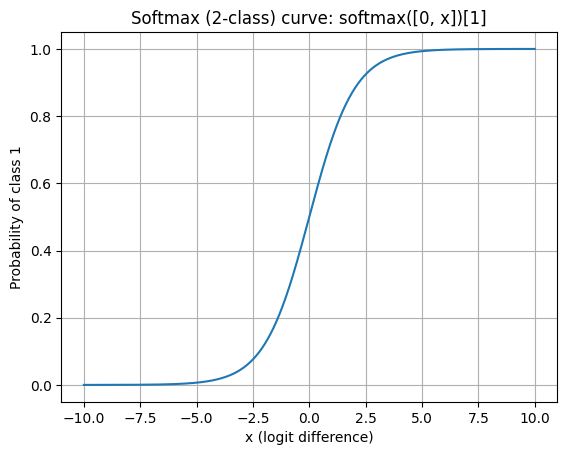

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def softmax(logits, axis=-1, T=1.0):
    """
    数值稳定的 softmax，支持温度 T
    logits: np.ndarray
    axis: softmax 归一化的维度
    T: 温度(>0)，T 越小分布越尖锐，T 越大分布越平坦
    """
    logits = np.asarray(logits, dtype=np.float64)
    scaled = logits / T
    scaled = scaled - np.max(scaled, axis=axis, keepdims=True)  # 稳定性
    exp = np.exp(scaled)
    return exp / np.sum(exp, axis=axis, keepdims=True)
# ---------------------------
# 图1：二分类 softmax 曲线（等价 sigmoid）
# ---------------------------
x = np.linspace(-10, 10, 600)              # 输入差值
logits_2 = np.stack([np.zeros_like(x), x], axis=1)  # [0, x]
p_class1 = softmax(logits_2, axis=1)[:, 1]

plt.figure()
plt.plot(x, p_class1)
plt.title("Softmax (2-class) curve: softmax([0, x])[1]")
plt.xlabel("x (logit difference)")
plt.ylabel("Probability of class 1")
plt.ylim(-0.05, 1.05)
plt.grid(True)

当$d_{k}$增大时，意味着$Q_i$和$K_i$之间的点乘操作会增加，只要$Q_iK_i$稍微比其他值大一点，经过softmax之后绝大部分值就会变得很小，接近于0，使得其梯度很小。<br>
softmax函数对输入值的量级机器敏感：<br>
1、数值溢出问题：若点积的绝对值随d_{k}增大而显著增大，输入softmax的值可能超出浮点数表示范围。<br>2、梯度消失问题：当某些点积值远大于其他值时，softmax输出接近独热分布，导致梯度接近于零，阻碍参数更新。<br>3、分布退化问题：未经缩放的输入会使注意力权重集中在少数位置，失去软性关注的优势。<br>

#### 4.2.4 除以$\sqrt{d_{k}}$的数学解释
通过点积除以$\sqrt{d_{k}}$，可以将点积的标准差从$\sqrt{d_{k}}$缩放至1，即：<br>
\begin{aligned}
\operatorname{Var}\!\left( \frac{Q \cdot K}{\sqrt{d_k}} \right)
= \frac{\operatorname{Var}(Q \cdot K)}{d_k}
= 1
\end{aligned}
<br>
此时，点积的分布被标准化为正态分布，实现了一下效果：<br>1、数值稳定性：softmax输入的均值为0、方差为1，避免极端值。<br>2、梯度均衡性：softmax输出的概率分布更平缓，梯度更新更稳定。<br>3、模型鲁棒性：注意力权重在多位置间合理分配，保留软性关注能力。<br>

**为何不是其他缩放因子**<br>
从正态分布的角度看，除以的本质是通过方差归一化，将点积的统计特性控制在合理范围内。若采用其他缩放因子如$d_{k}$和$2\sqrt{d_{k}}$。
除以$d_{k}$：方差将缩小至$1/d_{k}$，导致softmax输入过小，注意力权重趋于平均分布，失去分区性。
除以$2\sqrt{d_{k}}$：方差将缩小为$1/4$，输入量级过小，同样影响注意力权重的有效性。<br>

#### 4.2.5 相关代码
**1.nn.Linear()**<br>
nn.Linear是一个非常重要的模块，用于创建一个全连接层，也就是神经网络中的线性层，这个层会对输入数据应用一个线性变换，即y=xA^T+b，其中x就是输入数据，A是层的权重，b是偏置项。<br>
只需要指定输入和输出的特征数量即可
import torch.nn as nn<br>
linear_layer = nn.Linear(in_features=64, out_features=10)在这个例子中，in_features的参数指的是每个输入样本的大小，而out_feautres参数指的是每个输出样本的大小。如果bias为True（默认值），这个层还会学习一个加法偏置。<br>
nn.Linear模块的权重和偏置参数会自动初始化。权重通常从一个均匀分布U(-k,k)中初始化，其中k=1/in_feautres。如果bias为true，偏置也会从同样的分布中初始化。<br>
下面假设输入形状为[128, 20]的输入张量，想通过全连接层转换为[128,30]的输出张量

In [2]:
import torch.nn as nn
import torch
m = nn.Linear(20,30) # 创建一个全连接层
input_tensor = torch.randn(128,20)  # 创建一个随机输入张量
output_tensor = m(input_tensor)
print(output_tensor.size())

torch.Size([128, 30])


In [3]:
## torch.bmm函数用于批量矩阵乘法，计算两个3D张量的矩阵乘法
## input形状为(b,n,m)，mat2形状为(b,m,p)，torch.bmm(input,mat2)返回一个形状为(b,n,p)的张量
import torch
input_ = torch.randn(10,3,4)
mat2 = torch.randn(10,4,5)
result = torch.bmm(input_,mat2)
print(result.size())

torch.Size([10, 3, 5])


**2. torch.softmax() 三维tensor(C,H,W)**<br>
三维tensor(C,H,W)一般会设置成dim=0,1,2,-1，其中2与-1等价
<div align="center">
   <img src="./pics/rs_1.jpg" width="450" />
</div>
当dim=0时，是对每一维度相同位置的数值进行softmax运算，和为1<br>
当dim=1时，是对某一维度的列进行softmax运算，和为1<br>
当dim=2时，是对某一维度的行进行softmax运算，和为1<br>

In [4]:
import torch
import torch.nn.functional as F
input_tensor = torch.randn(2,5,4)
print(input_tensor)
dim_0 = F.softmax(input_tensor,dim=0)
print('dim=0时的softmax:\n',dim_0)
dim_1 = F.softmax(input_tensor,dim=1)
print('dim=0时的softmax:\n',dim_1)
dim_2 = F.softmax(input_tensor,dim=2)
print('dim=2时的softmax:\n',dim_2)
dim_11 = F.softmax(input_tensor,dim=-1)
print('dim=-1时的softmax:\n',dim_11)

tensor([[[-0.1011,  0.0708,  0.6331, -1.0106],
         [ 0.0494, -0.2813,  1.8188,  0.2431],
         [ 0.8531,  0.2308,  0.4322,  1.5309],
         [-0.7469,  0.1895, -1.3837, -0.6433],
         [-0.1806, -1.8544,  0.3095,  1.4771]],

        [[ 0.4728,  0.9709,  0.3050,  1.0377],
         [ 1.0193, -1.0950, -0.4635,  1.1161],
         [-2.2723, -1.3519,  1.1913, -0.3234],
         [ 0.5234,  1.6212, -0.2235,  0.2012],
         [ 0.0853,  2.5540, -0.0459,  0.5872]]])
dim=0时的softmax:
 tensor([[[0.3603, 0.2890, 0.5813, 0.1142],
         [0.2749, 0.6929, 0.9074, 0.2946],
         [0.9579, 0.8296, 0.3188, 0.8646],
         [0.2192, 0.1928, 0.2386, 0.3006],
         [0.4339, 0.0120, 0.5879, 0.7089]],

        [[0.6397, 0.7110, 0.4187, 0.8858],
         [0.7251, 0.3071, 0.0926, 0.7054],
         [0.0421, 0.1704, 0.6812, 0.1354],
         [0.7808, 0.8072, 0.7614, 0.6994],
         [0.5661, 0.9880, 0.4121, 0.2911]]])
dim=0时的softmax:
 tensor([[[0.1611, 0.2410, 0.1681, 0.0326],
         [0.187

**3.四维tensor(B,C,H,W)**
是三维tensor的推广，三维tensor可以理解为batchsize=1的四维tensor，dim取值0,1,2,3,-1

In [5]:
import torch
import torch.nn.functional as F
input_tensor = torch.randn(2,2,5,4)
print(input_tensor)
dim_3 = F.softmax(input_tensor,dim=-1)
print('dim=-1时的softmax:\n',dim_3)
dim_2 = F.softmax(input_tensor,dim=2)
print('dim=2时的softmax:\n',dim_2)
dim_1 = F.softmax(input_tensor,dim=1)
print('dim=1时的softmax:\n',dim_1)
dim_0 = F.softmax(input_tensor,dim=0)
print('dim=0时的softmax:\n',dim_0)

tensor([[[[ 6.4230e-02,  9.8550e-01, -2.1708e+00, -3.2067e-01],
          [-2.0511e-01, -5.2827e-01, -1.2569e+00, -4.6668e-01],
          [ 1.0538e+00, -1.8405e-01, -1.6660e+00,  2.0825e+00],
          [-1.8182e+00,  5.7939e-01,  4.1039e-01,  3.8453e-01],
          [-1.1243e+00,  9.2927e-01,  5.0012e-01, -7.3924e-01]],

         [[-1.1755e+00,  1.9211e+00,  3.3047e-01, -1.0927e-01],
          [ 1.6637e+00, -1.0266e+00,  1.7937e+00, -1.6044e-01],
          [ 1.4380e+00, -5.1217e-01, -1.5287e-01, -1.2506e+00],
          [-1.7052e-01,  9.5380e-01, -4.5312e-01,  3.2709e-01],
          [-1.0373e+00, -8.4609e-01,  1.5362e-01,  8.1152e-01]]],


        [[[ 8.5583e-01,  8.3817e-01, -1.2600e+00, -4.0731e-02],
          [ 1.5253e+00, -2.3411e+00,  2.4279e-01, -1.7466e+00],
          [-1.7125e+00, -9.2793e-01,  1.0825e+00,  4.7439e-02],
          [-3.2579e-01,  1.3056e-01, -9.0455e-01,  2.1987e-03],
          [-6.6215e-01,  4.7681e-01,  1.7130e+00,  1.8512e-01]],

         [[-1.2668e+00,  1.0630e

In [6]:
import math
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, dim_input, dim_q, dim_v):
        """
        参数说明：
        dim_input:输入数据x中每一个样本的向量维度
        dim_q: Q矩阵的列向维度，在运行时dim_q和dim_k保持一致
               因为需要进行：Q*K^T运算，结果为[seq_len, sen_len]方阵
        dim_v：V矩阵的列向维度，巨顶了输出数据attention的列向维度
        """
        super(SelfAttention,self).__init__()
        self.dim_input = dim_input
        self.dim_q = dim_q
        self.dim_k = dim_q
        self.dim_v = dim_v
        
        #定义线性变换函数
        self.linear_q = nn.Linear(self.dim_input, self.dim_q, bias=False)
        self.linear_k = nn.Linear(self.dim_input, self.dim_k, bias=False)
        self.linear_v = nn.Linear(self.dim_input, self.dim_v, bias=False)
        self._norm_fact = 1/math.sqrt(self.dim_k)
    
    def forward(self,x):
        batch, n, dim_q = x.shape
        q=self.linear_q(x)
        k=self.linear_k(x)
        v=self.linear_v(x)
        print(f'x.shape:{x.shape} \n q.shape:{q.shape} \n v.shape:{v.shape} \n')
        dist = torch.bmm(q, k.transpose(1,2)) * self._norm_fact
        # 归一化获得attention的相关系数
        dist = torch.softmax(dist, dim=-1)
        print('attention matrix:',dist)
        print('attention matrix:', dist.shape)
        # score与v相乘，获得最终的输出
        att = torch.bmm(dist,v)
        print('attention output',att.shape)
        return att
if __name__ == '__main__':
    batch_size = 2  # 批量数
    dim_input = 5  # 每个单词的向量维度
    seq_len = 3 # 单词的数量
    x = torch.randn(batch_size,seq_len,dim_input)
    self_attention = SelfAttention(dim_input, 10, 12)
    print(x)
    print('=='*30)
    attention = self_attention(x)
    print('=='*30)
    print(attention)

tensor([[[-0.3249,  0.7005, -1.2044, -0.9758, -0.8673],
         [-0.4385,  0.3788,  0.1748,  2.2754, -0.7355],
         [ 0.6986, -0.2461,  0.0369,  0.7034, -0.0934]],

        [[ 1.3216, -0.6408,  1.4179,  1.3581,  1.1613],
         [ 0.1897, -0.3463, -0.3204, -1.7070, -1.6831],
         [-0.6015,  1.4491, -1.5617,  0.1285, -0.5952]]])
x.shape:torch.Size([2, 3, 5]) 
 q.shape:torch.Size([2, 3, 10]) 
 v.shape:torch.Size([2, 3, 12]) 

attention matrix: tensor([[[0.3864, 0.3251, 0.2885],
         [0.2414, 0.4261, 0.3325],
         [0.3376, 0.3496, 0.3128]],

        [[0.4122, 0.3277, 0.2602],
         [0.1905, 0.3459, 0.4636],
         [0.2905, 0.3082, 0.4013]]], grad_fn=<SoftmaxBackward0>)
attention matrix: torch.Size([2, 3, 3])
attention output torch.Size([2, 3, 12])
tensor([[[ 0.2509,  0.0806, -0.0490,  0.2995, -0.2628, -0.4928,  0.3531,
          -0.5317,  0.1964, -0.0988, -0.0994,  0.1742],
         [ 0.2587, -0.0673, -0.2097,  0.2285, -0.3965, -0.6330,  0.4293,
          -0.6253,  

## 5. 面试提问
1. 介绍一下你简历中提到的非线性transformer，跟常见的transformer有什么不同? 